#### Apéndice A
## Cálculo de ARIMA con librerias hechas en python

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from pathlib import Path



### Carga de datos

In [54]:
ROOT = Path.cwd().resolve().parent
DATA = ROOT / "Data" 

In [55]:
train = pd.read_csv(DATA/'train.csv', index_col=0, parse_dates=True)
valid = pd.read_csv(DATA/'valid.csv', index_col=0, parse_dates=True)

# Asignamos frecuencia para evitar warnings
train.index.freq = 'ME'
valid.index.freq = 'ME'

y_train = train.iloc[:, 0]
y_valid = valid.iloc[:, 0]

### Identificación y Selección del Mejor Modelo

In [56]:
posibles_modelos = [(2, 0, 0), (3, 0, 0), (4, 0, 0), (2, 0, 1)]
resultados = []

print("Comparativa de Modelos:")
print(f"{'Modelo':<15} | {'AIC':<12} | {'SSE':<12}")
print("-" * 45)

for order in posibles_modelos:
    try:
        model = ARIMA(y_train, order=order)
        model_fit = model.fit()
        
        resultados.append({
            'Orden': order,
            'AIC': model_fit.aic,
            'SSE': model_fit.sse,
            'Modelo': model_fit
        })
        print(f"ARIMA{str(order):<10} | {model_fit.aic:.4f}      | {model_fit.sse:.4f}")
    except Exception as e:
        print(f"Falló ARIMA{order}: {e}")
        continue

Comparativa de Modelos:
Modelo          | AIC          | SSE         
---------------------------------------------
ARIMA(2, 0, 0)  | 27587.2008      | 2051468.7846
ARIMA(3, 0, 0)  | 27488.5736      | 1982343.9303
ARIMA(4, 0, 0)  | 27432.0915      | 1943238.8504
ARIMA(2, 0, 1)  | 27420.7252      | 1937063.7339


### Seleccionar el modelo con el menor AIC

In [57]:
mejor_resultado = min(resultados, key=lambda x: x['AIC'])
mejor_modelo = mejor_resultado['Modelo']
mejor_orden = mejor_resultado['Orden']

print(f"\nMejor modelo seleccionado: ARIMA{mejor_orden}")


Mejor modelo seleccionado: ARIMA(2, 0, 1)


### Estimación

In [58]:
print(f"\nResumen del Mejor Modelo (ARIMA{mejor_orden}):")
print(mejor_modelo.summary())


Resumen del Mejor Modelo (ARIMA(2, 0, 1)):
                                       SARIMAX Results                                       
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 2938
Model:                                ARIMA(2, 0, 1)   Log Likelihood              -13705.363
Date:                               Thu, 11 Dec 2025   AIC                          27420.725
Time:                                       23:57:03   BIC                          27450.653
Sample:                                   01-31-1749   HQIC                         27431.501
                                        - 10-31-1993                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.1124     16.104      5.223   

### Validación

In [59]:
# 1. Validación de Residuos (Ruido Blanco)
residuos = mejor_modelo.resid
lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print("\nTest de Ljung-Box (Residuos):")
print(lb_test)

# 2. Validación con datos de prueba (RMSE)
predicciones = mejor_modelo.forecast(steps=len(y_valid))
rmse = np.sqrt(mean_squared_error(y_valid, predicciones))
print(f"\nRMSE en validación: {rmse:.4f}")


Test de Ljung-Box (Residuos):
      lb_stat     lb_pvalue
10  56.338189  1.774167e-08

RMSE en validación: 59.6175


### Predicción

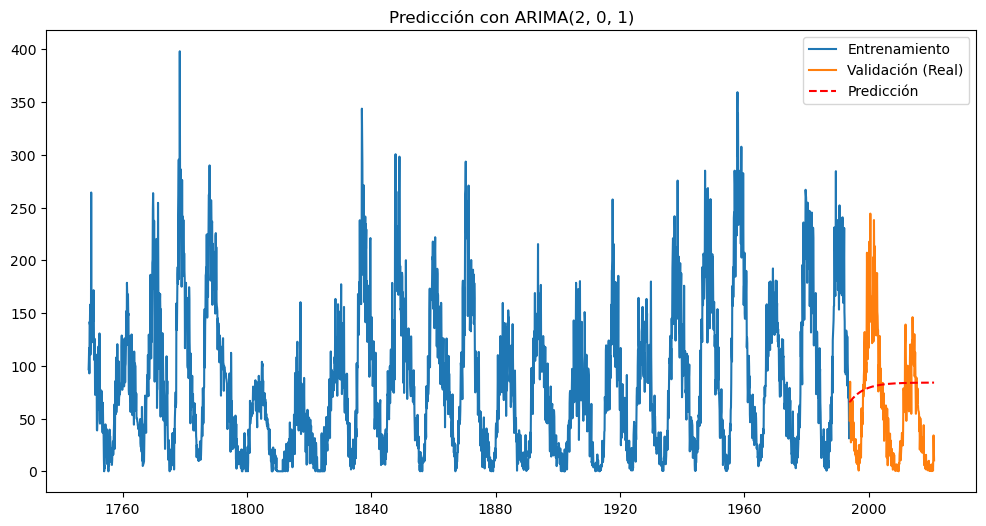

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Entrenamiento')
plt.plot(y_valid.index, y_valid, label='Validación (Real)')
plt.plot(y_valid.index, predicciones, label='Predicción', color='red', linestyle='--')
plt.title(f'Predicción con ARIMA{mejor_orden}')
plt.legend()
plt.show()

La primera gráfica muestra una línea plana debido a que el pronóstico estático a largo plazo en modelos estacionarios converge inevitablemente a la media histórica por falta de información nueva; en contraste, la segunda gráfica implementa una validación dinámica (Rolling Forecast) que actualiza el historial con cada dato real observado, permitiendo que el modelo refresque su memoria a corto plazo y capture con precisión los ciclos estacionales.

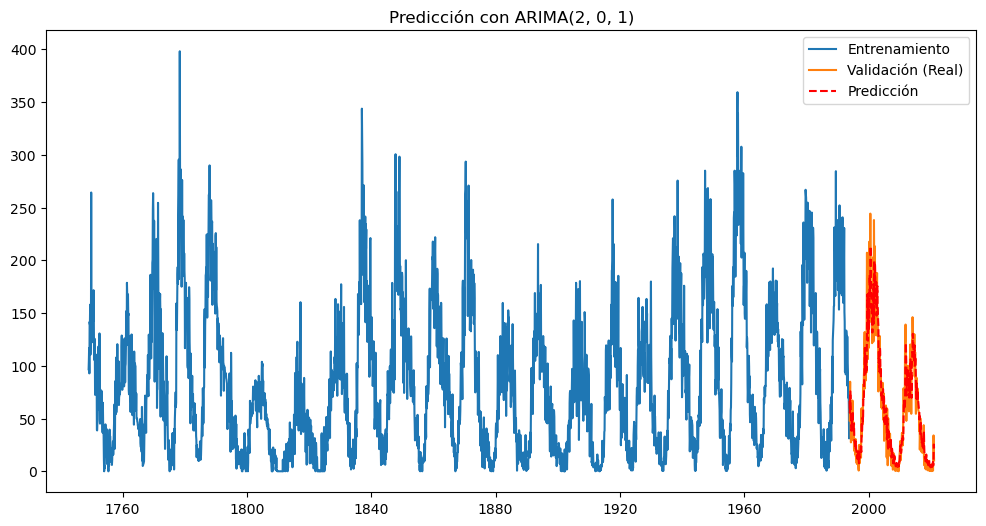

In [61]:
history = [x for x in y_train]
predicciones = []

# Walk-forward validation
for t in range(len(y_valid)):
    # Se re-entrena o se actualiza el modelo en cada paso
    model = ARIMA(history, order=mejor_orden)
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predicciones.append(yhat)
    
    # Añadimos la observación real para la siguiente predicción
    obs = y_valid.iloc[t]
    history.append(obs)

plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Entrenamiento')
plt.plot(y_valid.index, y_valid, label='Validación (Real)')
plt.plot(y_valid.index, predicciones, label='Predicción', color='red', linestyle='--')
plt.title(f'Predicción con ARIMA{mejor_orden}')
plt.legend()
plt.show()

### Guardar predicciones

In [62]:
predicciones_df = pd.DataFrame(predicciones)
predicciones_df.columns = ['Prediccion']

In [63]:
predicciones_df

,Prediccion
0,66.679189
1,55.502197
2,64.733590
3,75.740517
4,62.136948
...,...
322,8.969308
323,5.488123
324,12.620743
325,25.391413
